In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import stan  # pystan
from scipy.stats import mstats  # 信頼区間の描画のために、、、
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/dose_response.xlsx")

In [4]:
df.head()

,log10 C,death
0,0.95,0
1,0.94,0
2,0.95,0
3,0.96,0
4,0.99,0


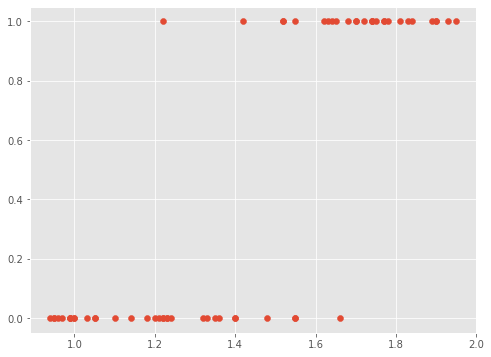

In [5]:
plt.figure(figsize=(8,6))

plt.scatter(df["log10 C"], df["death"]);

In [6]:
stan_model = """
data {
  int N;
  real X[N];
  int<lower=0, upper=1> Y[N];
}

parameters {
  real a;
  real b;
}

model {
  for (n in 1:N){
    Y[n] ~ bernoulli_logit(a * X[n] + b);
  }
}

"""

In [7]:
stan_data = {"N":df.shape[0], 
             "X":df["log10 C"].values, 
             "Y":df["death"].values}

In [8]:
# sm = pystan.StanModel(model_code= stan_model)
# fit = sm.sampling(data = stan_data, iter = 2000, warmup=500, chains=3, seed=123)
# fit

In [9]:
import nest_asyncio
nest_asyncio.apply()

In [10]:
posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample(num_chains=3, num_samples=1500, num_warmup=500, save_warmup=0)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_z5hmrnwm/model_qp64nait.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_z5hmrnwm/model_qp64nait.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  33% (2000/6000)
Sampling:  67% (4000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 4.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.48 seconds.
  Adjust you

In [11]:
df_fit = fit.to_frame()
df_fit.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,4500.0,-14.952905,1.109142,-22.470864,-15.387375,-14.597837,-14.174291,-13.864860
accept_stat__,4500.0,0.930826,0.107433,0.002203,0.912027,0.975530,0.996583,1.000000
stepsize__,4500.0,0.074681,0.015582,0.058821,0.058821,0.069365,0.095858,0.095858
treedepth__,4500.0,3.194000,1.366708,1.000000,2.000000,3.000000,4.000000,6.000000
n_leapfrog__,4500.0,19.258222,17.078457,1.000000,3.000000,15.000000,31.000000,79.000000
divergent__,4500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,4500.0,15.955715,1.501836,13.885605,14.847779,15.588878,16.682155,25.762836
a,4500.0,13.787907,3.535925,5.677340,11.335895,13.308924,15.603854,32.615800
b,4500.0,-20.577471,5.364625,-49.289696,-23.364851,-19.897863,-16.867245,-8.357957


In [12]:
# a, b = 13.83, -20.64
a, b = 13.78, -20.57

In [13]:
# fig = fit.plot()

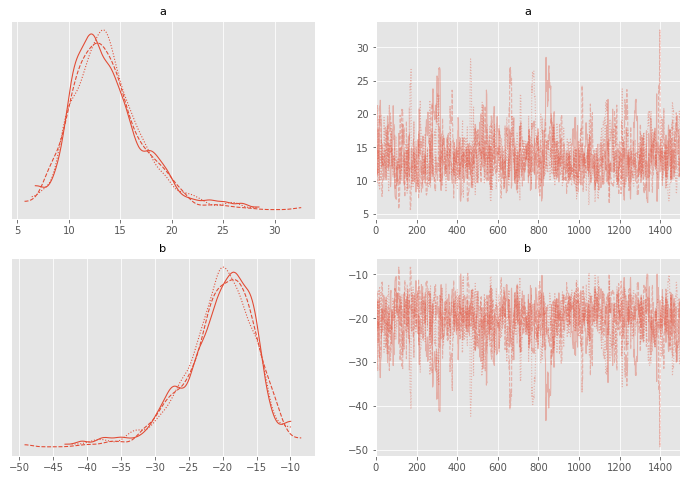

In [14]:
import arviz
arviz.plot_trace(fit, figsize=(12,8));

ベイズ信頼区間の確認

In [15]:
# ms_a = fit.extract("a")["a"]
# ms_b = fit.extract("b")["b"]

ms_a = df_fit["a"]
ms_b = df_fit["b"]

In [16]:
x = np.arange(1.0, 2.0, 0.01)  # 範囲定義

f = lambda x : 1.0 / (1.0 + np.exp(-x))  # ロジスティクス関数を定義しておく

df_b = pd.DataFrame([])
for i in range(x.shape[0]):
    df_b[i] = f(ms_a * x[i] + ms_b)

In [17]:
df_b.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
draws,,,,,,,,,,,,,,,,,,,,,
0,0.002373,0.002666,0.002995,0.003364,0.003778,0.004244,0.004766,0.005352,0.006010,0.006749,...,0.988503,0.989755,0.990873,0.991869,0.992758,0.993550,0.994256,0.994885,0.995445,0.995944
1,0.008322,0.009393,0.010602,0.011963,0.013497,0.015225,0.017170,0.019359,0.021820,0.024587,...,0.998011,0.998239,0.998442,0.998621,0.998779,0.998919,0.999044,0.999153,0.999251,0.999337
2,0.001023,0.001192,0.001388,0.001617,0.001883,0.002194,0.002555,0.002975,0.003465,0.004034,...,0.998960,0.999108,0.999234,0.999342,0.999436,0.999515,0.999584,0.999643,0.999694,0.999737
3,0.002444,0.002742,0.003076,0.003450,0.003870,0.004340,0.004868,0.005459,0.006122,0.006864,...,0.987372,0.988731,0.989946,0.991030,0.991998,0.992863,0.993635,0.994324,0.994938,0.995487
4,0.005163,0.005813,0.006545,0.007368,0.008294,0.009336,0.010506,0.011822,0.013300,0.014960,...,0.995836,0.996303,0.996717,0.997085,0.997412,0.997703,0.997961,0.998190,0.998393,0.998573


In [18]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

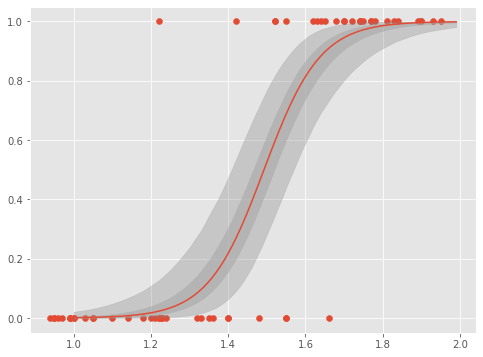

In [19]:
plt.figure(figsize=(8,6))

plt.scatter(df["log10 C"], df["death"])

plt.fill_between(x, low_y95, high_y95, alpha = 0.3, color = "gray")
plt.fill_between(x, low_y50, high_y50, alpha = 0.6, color = "darkgray")

plt.plot(x, f(a*x+b))

plt.show();